<a href="https://colab.research.google.com/github/rushikeshnakhate/PortfoliOpt/blob/master/multi_dates_post_processing_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import yfinance as yf
import pandas as pd
import numpy as np
from pathlib import Path
import os
output_dir = Path("/content/drive/MyDrive/")
data_dir = Path("/content/drive/MyDrive/data")
import matplotlib.pyplot as plt
# !pip install tqdm
# !pip install PyPortfolioOpt
# !pip install tabulate
# !pip install dtale
# !pip install -q data-table
import scipy.optimize as sci_opt
from tqdm import tqdm  # Import the tqdm progress b
from google.colab import data_table

# !rm -rf output_dir/MyDrive/data
# !rm -rf output_dir/MyDrive/data*

In [48]:
import tarfile

def unzip_files():
  from google.colab import files
  import zipfile

  # After uploading, you can unzip the file
  import zipfile
  import os


  zip_filename = '/content/drive/MyDrive/data.zip'
  # Replace 'data.zip' with the name of your uploaded zip file
  with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
      zip_ref.extractall(output_dir)

  tar_filename = '/content/drive/MyDrive/data.tar.gz'
  # with tarfile.open(tar_filename, 'r:gz') as tar_ref:
  #   tar_ref.extractall(output_dir)

  print("Directory uploaded and extracted successfully to Google Drive.")
unzip_files()

Directory uploaded and extracted successfully to Google Drive.


In [49]:
from datetime import datetime, timedelta
def generate_month_date_ranges(year, months=None):
    """Generate start_date and end_date (without time) for each month in the specified year.

    Args:
        year (int): The year for which to generate the month ranges.
        months (list of int, optional): Specific months to generate ranges for (1-12).

    Returns:
        list of tuples: Each tuple contains the start and end date for the specified months.
    """
    if months is None:
        months = range(1, 13)  # Default to all months if none specified

    month_ranges = []
    for month in months:
        start_date = datetime(year, month, 1).date()
        if month == 12:
            end_date = (datetime(year + 1, 1, 1) - timedelta(days=1)).date()
        else:
            end_date = (datetime(year, month + 1, 1) - timedelta(days=1)).date()
        month_ranges.append((start_date, end_date))

    return month_ranges

def create_current_month_directory(start_date, output_dir):
    current_month = start_date.strftime("%Y%m")
    current_month_dir = output_dir / current_month
    # current_month_dir.rmdir(parents=True, exist_ok=True)
    return current_month_dir

In [50]:
from google.colab import data_table

# Assuming df is your DataFrame
def clean_metadata(value):
    if isinstance(value, pd.Series):
        return value.values  # Extract just the values
    elif isinstance(value, list):
        return [str(v) for v in value]  # Convert each element to string for clarity
    return value

def extract_value(value):
    # Check if the value is a list and has only one element, then extract it
    # print(type(value))
    if isinstance(value, (np.ndarray, list)) and len(value) == 1:
        return value[0]
    # elif isinstance(value, tuple) and len(value) >= 2:
    #   return value[1]
    return value  # Return the value as-is if not a list



In [51]:
def load_data_and_plot(start_date, data_dir, plot_func):
    """
    Function to load data for a specific date range and plot using the given plot function.

    Args:
    start_date (datetime): The start date of the month for data loading.
    data_dir (str): The directory where the data is stored.
    plot_func (function): A function to plot the data (either bar plot or 3D plot).
    """
    current_month_dir = create_current_month_directory(start_date, data_dir)
    # data_pkl_filepath = os.path.join(current_month_dir, "data.pkl")
    # expected_return_pkl_filepath = os.path.join(current_month_dir, "expected_return.pkl")
    # optimization_pkl_filepath = os.path.join(current_month_dir, "optimization.pkl")
    perforamnce_pkl_filepath = os.path.join(current_month_dir, "post_processing_weight.pkl")

    # Load data
    # data = pd.read_pickle(data_pkl_filepath)
    # expected_return_df = pd.read_pickle(expected_return_pkl_filepath)
    # optimization_df = pd.read_pickle(optimization_pkl_filepath)
    performance_df = pd.read_pickle(perforamnce_pkl_filepath)



    # display(post_processing_df)
    # Format the month as 'YYYY-MM' for the title
    current_month = start_date.strftime('%Y-%m')
    # Call the provided plot function
    # print("using optimization_pkl_filepath=optimization_pkl_filepath{}".format(optimization_pkl_filepath))
    return plot_func(performance_df)

In [58]:
# Update the ranking functions to return the top 10 for best and worst portfolios
target_columns = ['Sharpe Ratio','Annual Volatility','Expected Return Type', 'Risk Model', 'Optimizer', 'Expected Annual Return', 'Weights','Allocation_GreedyPortfolio_weight','Allocation_LpPortfolio_weight','Allocation_GreedyPortfolio_remaining_amount','Allocation_LpPortfolio_remaining_amount']
# target_columns = ['Sharpe Ratio','Annual Volatility','Expected Return Type', 'Risk Model', 'Optimizer', 'Expected Annual Return',  'Weights','Allocation_GreedyPortfolio_weight','Allocation_LpPortfolio_weight']
# Function to rank portfolios based on 'Expected Annual Return', 'GreedyPortfolio_Return', and 'LpPortfolio_Return'
def rank_by_annual_return(df1):
    df = df1.copy()
    # Sort by 'Expected Annual Return'
    df_ranked = df[target_columns]
    best_portfolio_return = df_ranked.nlargest(10, 'Expected Annual Return')  # Top 10 highest return
    worst_portfolio_return = df_ranked.nsmallest(10, 'Expected Annual Return')  # Top 10 lowest return

    return best_portfolio_return, worst_portfolio_return

# Function to rank portfolios based on 'Annual Volatility', 'GreedyPortfolio_Volatility', and 'LpPortfolio_Volatility'
def rank_by_volatility(df1):
    df = df1.copy()
    # Sort by 'Annual Volatility'
    df_ranked = df[target_columns]
    best_portfolio_vol = df_ranked.nsmallest(10, 'Annual Volatility')  # Top 10 smallest volatility (best)
    worst_portfolio_vol = df_ranked.nlargest(10, 'Annual Volatility')  # Top 10 largest volatility (worst)

    return best_portfolio_vol, worst_portfolio_vol

# Function to rank portfolios based on 'Sharpe Ratio', 'GreedyPortfolio_Sharpe', and 'LpPortfolio_Sharpe'
def rank_by_sharpe_ratio(df1):
    df = df1.copy()
    # Sort by 'Sharpe Ratio'
    df_ranked = df[target_columns]
    best_portfolio_sharpe = df_ranked.nlargest(10, 'Sharpe Ratio')  # Top 10 highest Sharpe ratios (best)
    worst_portfolio_sharpe = df_ranked.nsmallest(10, 'Sharpe Ratio')  # Top 10 lowest Sharpe ratios (worst)

    return best_portfolio_sharpe, worst_portfolio_sharpe

# # Assuming filtered_df is already defined, executing the updated functions
# best_return, worst_return = rank_by_annual_return(filtered_df)
# best_volatility, worst_volatility = rank_by_volatility(filtered_df)
# best_sharpe, worst_sharpe = rank_by_sharpe_ratio(filtered_df)

# best_return, worst_return, best_volatility, worst_volatility, best_sharpe, worst_sharpe


# # # Executing the functions
# best_return, worst_return = rank_by_annual_return(filtered_df)
# best_volatility, worst_volatility = rank_by_volatility(filtered_df)
# best_sharpe, worst_sharpe = rank_by_sharpe_ratio(filtered_df)

In [72]:
from sklearn.preprocessing import MinMaxScaler

# Function to normalize data and plot
def plot_portfolio_comparison_normalized(df):
    """
    Function to normalize Expected Annual Return, Annual Volatility, and Sharpe Ratio
    for better visualization in a single plot.

    Parameters:
    df (pd.DataFrame): DataFrame containing portfolio information with columns:
                       - 'Optimizer' (e.g., Greedy, LP)
                       - 'Expected Annual Return'
                       - 'Annual Volatility'
                       - 'Sharpe Ratio'
    """
    # Select the columns to normalize
    metrics = ['Expected Annual Return', 'Annual Volatility', 'Sharpe Ratio']

    # Apply Min-Max Scaling
    scaler = MinMaxScaler()
    df[metrics] = scaler.fit_transform(df[metrics])

    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))
    fig.suptitle('Comparison of Normalized Expected Return, Volatility, and Sharpe Ratio: Greedy vs LP', fontsize=16)

    # Plot 1: Normalized Expected Annual Return
    sns.barplot(x='Optimizer', y='Expected Annual Return', data=df, palette='Set2', ax=axes[0])
    axes[0].set_title('Normalized Expected Annual Return')
    axes[0].tick_params(axis='x', rotation=90)

    # Plot 2: Normalized Annual Volatility
    sns.barplot(x='Optimizer', y='Annual Volatility', data=df, palette='Set3', ax=axes[1])
    axes[1].set_title('Normalized Annual Volatility')
    axes[1].tick_params(axis='x', rotation=90)

    # Plot 3: Normalized Sharpe Ratio
    sns.barplot(x='Optimizer', y='Sharpe Ratio', data=df, palette='Set1', ax=axes[2])
    axes[2].set_title('Normalized Sharpe Ratio')
    axes[2].tick_params(axis='x', rotation=90)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Call the function with your DataFrame
# plot_portfolio_comparison_normalized(df)  # Replace df with your actual DataFrame


start_date=2023-01-01,end_date2023-01-31


<ipython-input-72-6c709d1b65a9>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Optimizer', y='Expected Annual Return', data=df, palette='Set2', ax=axes[0])
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning

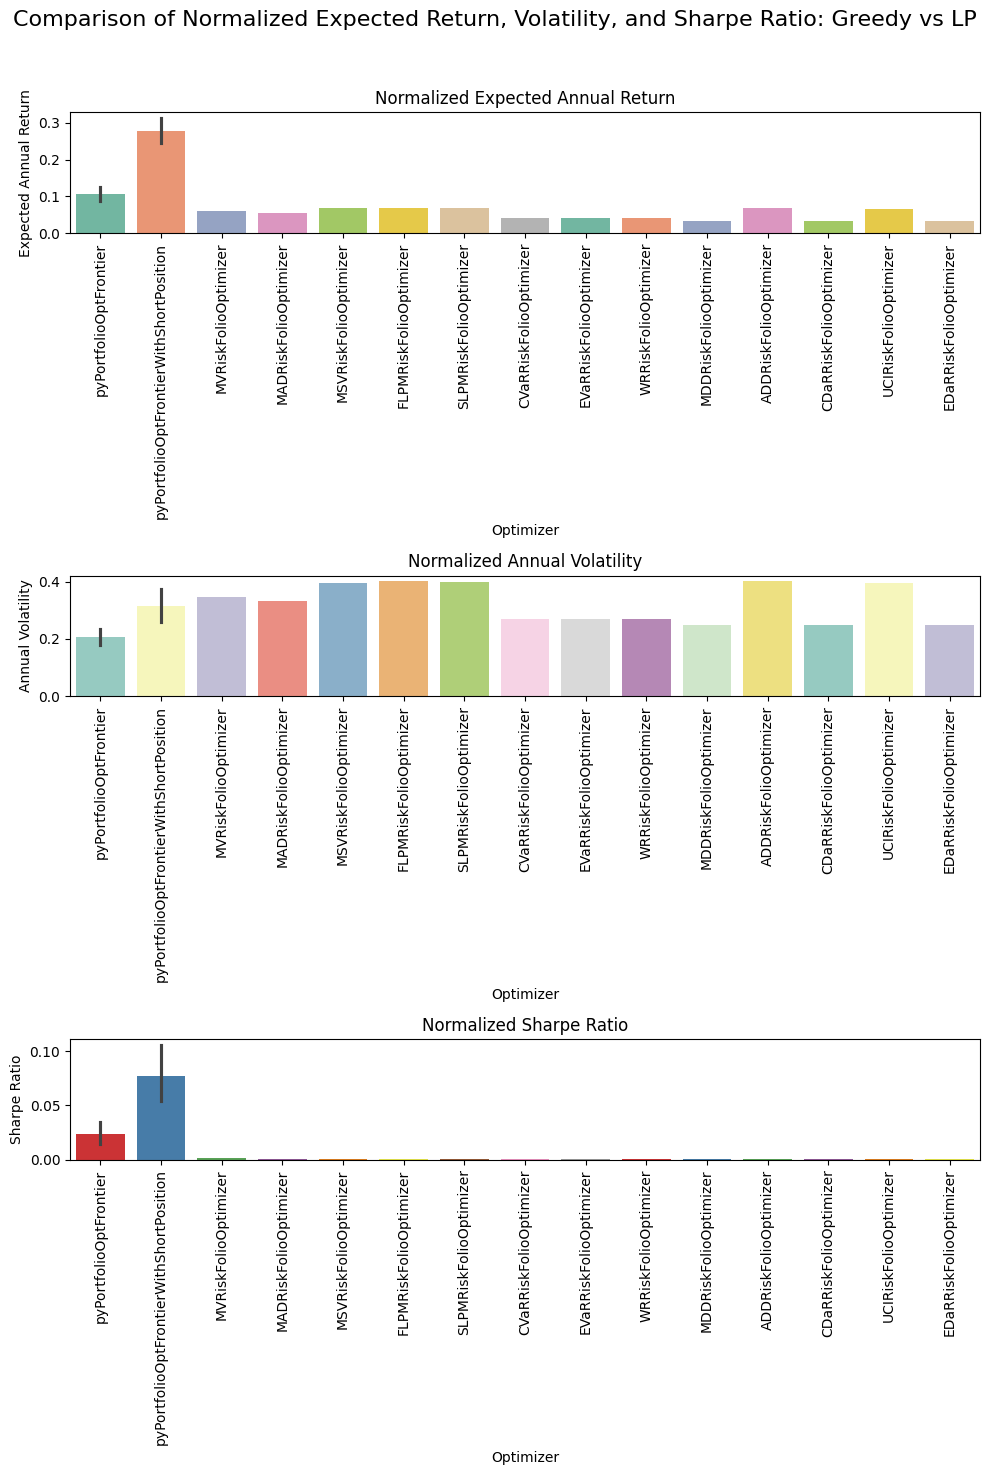

In [73]:
if __name__ == "__main__":
    year = 2023
    month_ranges = generate_month_date_ranges(year, months=[1])
    for start_date, end_date in month_ranges:
      print("start_date={},end_date{}".format(start_date, end_date))
      load_data_and_plot(start_date, data_dir, plot_portfolio_comparison_normalized)
      # compare_allocations(top_best)
      # data_table.DataTable(top_best)

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Function to normalize metrics and create a grouped bar plot
def plot_greedy_vs_lp_comparison_normalized(df):
    """
    Function to normalize Expected Annual Return, Annual Volatility,
    and Sharpe Ratio and create a grouped bar plot comparing Greedy and LP.

    Parameters:
    df (pd.DataFrame): DataFrame containing portfolio information with columns:
                       - 'Optimizer' (Greedy or LP)
                       - 'Expected Annual Return'
                       - 'Annual Volatility'
                       - 'Sharpe Ratio'
    """

    # Select the columns to normalize
    metrics = ['Expected Annual Return', 'Annual Volatility', 'Sharpe Ratio']

    # Apply Min-Max Scaling to normalize the metrics
    scaler = MinMaxScaler()
    df[metrics] = scaler.fit_transform(df[metrics])

    # Melt the DataFrame to have a single 'Metric' column for plotting
    metrics_df = pd.melt(df[['Optimizer', 'Expected Annual Return', 'Annual Volatility', 'Sharpe Ratio']],
                         id_vars='Optimizer',
                         var_name='Metric',
                         value_name='Value')

    # Create a grouped bar plot for the normalized metrics
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Metric', y='Value', hue='Optimizer', data=metrics_df, palette='Set2')

    # Set the plot title and labels
    plt.title('Normalized Greedy vs LP Comparison: Expected Return, Volatility, and Sharpe Ratio', fontsize=14)
    plt.ylabel('Normalized Value (0 to 1)')
    plt.xlabel('Metric')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example of calling the function with your DataFrame
# plot_greedy_vs_lp_comparison_normalized(df)  # Replace df with your actual DataFrame


start_date=2023-01-01,end_date2023-01-31


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

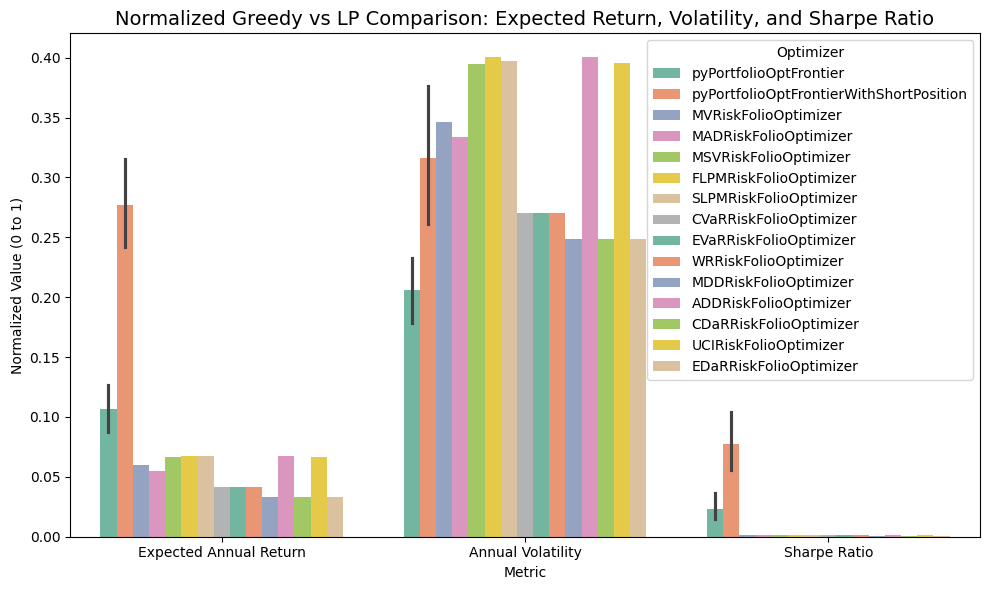

In [77]:
if __name__ == "__main__":
    year = 2023
    month_ranges = generate_month_date_ranges(year, months=[1])
    for start_date, end_date in month_ranges:
      print("start_date={},end_date{}".format(start_date, end_date))
      load_data_and_plot(start_date, data_dir, plot_greedy_vs_lp_comparison_normalized)
